In [332]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [333]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import dataframe_image as dfi

### Примеры входных данных

In [338]:
# пример кода для запуска генератора данных
from data_generator.data_generator import generate_data

N = 5
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21
seed = 19
data = generate_data(N, bounds_params, grid_size, seed)

In [340]:
# Пример данных для NLP постановки
# plu_line - код продуктовой линейки
# plu - код товара
# plu_idx - индекс товара
# P - текущая цена
# Q - текущие продажи в штуках
# E - эластичность
# PC - цена конкурента/рыночная цена
# C - себестоимость товара
# x_lower - нижняя граница x для диапазона поиска цены
# x_upper - верхняя граница x для диапазона поиска цены
# x_init - начальное значение x для старта оптимизатора
# fixed - метка, необходимо ли фиксировать x_init цену на товар, по умолчанию всегда 0
data['data_nlp']
# dfi.export(data['data_nlp'], './images/data_nlp_sample.png')

[0727/210834.958945:INFO:headless_shell.cc(660)] Written to file /var/folders/bn/zpkz54h12h91dlsrft_4kvp40000gn/T/tmpxfzozsvd/temp.png.


In [342]:
# Пример данных для MILP постановки
# plu_line - код продуктовой линейки
# P - текущая цена
# PC - цена конкурента/рыночная цена
# C - себестоимость товара
# Ps - сетка цен для поиска
# Qs - сетка продаж для кажой цены из Ps
# xs - сетка индексов
# grid_size - размер сетки
# P_idx - индекс текущей цены в сетке. Если значение -1, то текщая цена не попала в сетку
data['data_milp']
# dfi.export(data['data_milp'], './images/data_milp_sample.png')

[0727/210840.233613:INFO:headless_shell.cc(660)] Written to file /var/folders/bn/zpkz54h12h91dlsrft_4kvp40000gn/T/tmp05o45nec/temp.png.
[0727/210841.575496:INFO:headless_shell.cc(660)] Written to file /var/folders/bn/zpkz54h12h91dlsrft_4kvp40000gn/T/tmp88woaz61/temp.png.


### Отчет по времени работы и количеству "успешно" решенных задач

In [427]:
from runner import optimizers_collect_stat

In [428]:
stats_df = optimizers_collect_stat('./data/stat/')

In [429]:
stats_df['success'] = stats_df['status'] == 'ok'
stats_df['problem_type'] = np.where(
    stats_df['solver'].isin(['slsqp', 'trust-constr', 'ipopt']), 'nlp', 'lp'
)
time_rep_df = stats_df.groupby(['problem_type', 'solver', 'N'])['t'].describe().reset_index()


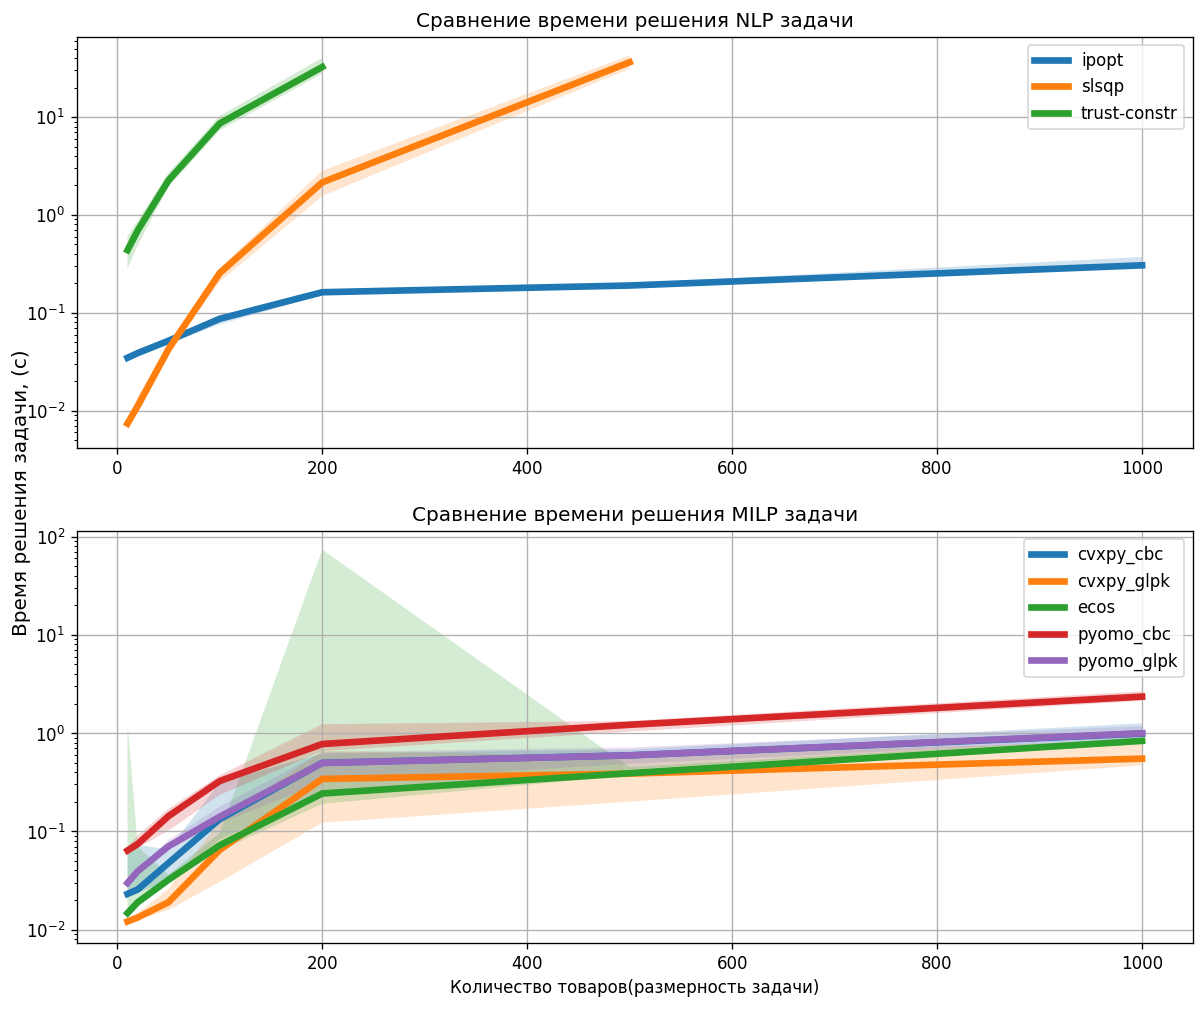

In [430]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharey=False, dpi=120)
for (pr_type, solver), df in time_rep_df.groupby(['problem_type', 'solver']):
    ax_id = 0 if pr_type == 'nlp' else 1
    axes[ax_id].plot(df['N'], df['50%'], lw=4, label=solver)
    axes[ax_id].fill_between(df['N'], df['25%'], df['75%'], alpha=0.2)
axes[0].set_title('Сравнение времени решения NLP задачи')
axes[1].set_title('Сравнение времени решения MILP задачи')
# [ax.set_xscale('log') for ax in axes]
[ax.set_yscale('log') for ax in axes]
[ax.legend(loc='upper right') for ax in axes]
[ax.grid() for ax in axes]
fig.text(0.08, 0.5, 'Время решения задачи, (с)', va='center', rotation='vertical', fontdict={'size': 12})
plt.xlabel('Количество товаров(размерность задачи)')
# plt.savefig('./images/time_solve_compare.png')
plt.show()


In [431]:
stats_df.groupby(['solver'])['success'].mean().reset_index().rename(columns={'success': 'success_rate'})


,solver,success_rate
0,cvxpy_cbc,1.00
1,cvxpy_glpk,1.00
2,ecos,0.76
3,ipopt,1.00
4,pyomo_cbc,1.00
5,pyomo_glpk,1.00
6,slsqp,1.00
7,trust-constr,0.96


### Пример запуска оптимизации

In [348]:
import numpy as np
import matplotlib.pyplot as plt
from data_generator.data_generator import generate_data
from optimizers.optimization import pricing_optimization
from optimizers.optimizers import (
    ScipyNlpOptimizationModel,
    PyomoNlpOptimizationModel,
    PyomoLpOptimizationModel,
    CvxpyLpOptimizationModel,
)

In [350]:
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21

data = generate_data(100, bounds_params, 21, 4)
M_cur = sum(data['data_nlp']['Q'] * (data['data_nlp']['P'] - data['data_nlp']['C']))
R_cur = sum(data['data_nlp']['Q'] * data['data_nlp']['P'])

opt_params = {
    'alpha': 0.0,
#     'con_mrg': M_cur,
    'con_equal': True
}

opt_params['alpha'] = 0.0
res, t =  pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
M_opt_min = sum((res['data']['P_opt'] - res['data']['C']) * res['data']['Q_opt'])

opt_params['alpha'] = 1.0
res, t =  pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
M_opt_max = sum((res['data']['P_opt'] - res['data']['C']) * res['data']['Q_opt'])

N_grid = 30
M_grid = np.linspace(M_opt_min, M_opt_max, N_grid)
R_norm_res = np.zeros(N_grid)
M_norm_res = np.zeros(N_grid)
R_res = np.zeros(N_grid)
M_res = np.zeros(N_grid)


opt_params['alpha'] = 0.0
for i, M in enumerate(M_grid):
    opt_params['con_mrg'] = M
    res, t = pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
    R_norm_res[i] = sum(res['data']['P_opt']  * res['data']['Q_opt']) / R_cur
    M_norm_res[i] = sum((res['data']['P_opt'] - res['data']['C'])  * res['data']['Q_opt']) / M_cur

    R_res[i] = sum(res['data']['P_opt']  * res['data']['Q_opt'])
    M_res[i] = sum((res['data']['P_opt'] - res['data']['C'])  * res['data']['Q_opt'])
    

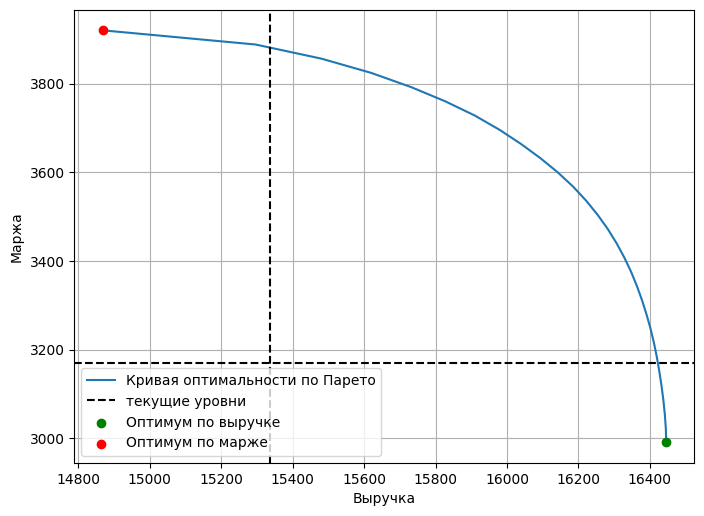

In [351]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(R_res, M_res, label='Кривая оптимальности по Парето')
plt.axvline(R_cur, ls='--', c='k', label='текущие уровни')
plt.axhline(M_cur, ls='--', c='k')
plt.scatter(R_res[0], M_res[0], c='g', label='Оптимум по выручке', zorder=2)
plt.scatter(R_res[-1], M_res[-1], c='r', label='Оптимум по марже', zorder=2)
plt.xlabel('Выручка')
plt.ylabel('Маржа')
plt.grid()
plt.legend()
plt.show()

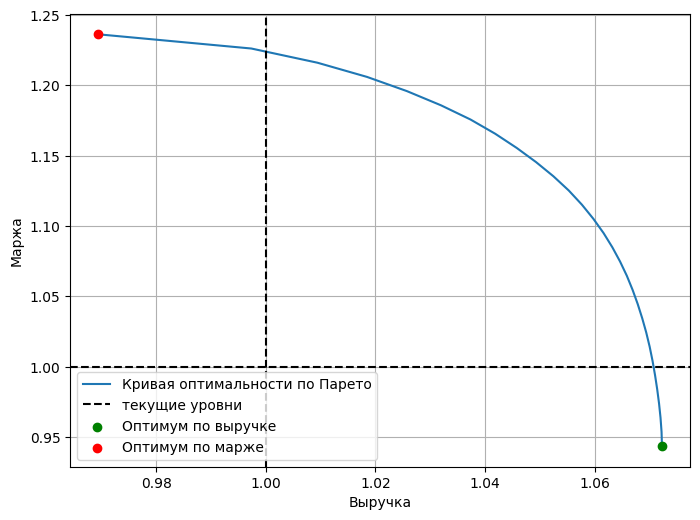

In [352]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(R_norm_res, M_norm_res, label='Кривая оптимальности по Парето')
plt.axvline(1, ls='--', c='k', label='текущие уровни')
plt.axhline(1, ls='--', c='k')
plt.scatter(R_norm_res[0], M_norm_res[0], c='g', label='Оптимум по выручке', zorder=2)
plt.scatter(R_norm_res[-1], M_norm_res[-1], c='r', label='Оптимум по марже', zorder=2)
plt.xlabel('Выручка')
plt.ylabel('Маржа')
plt.grid()
plt.legend()
plt.show()

### Проверка на прочность  при решении ~100000 товаров

In [774]:
%%time
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21


data = generate_data(1000, bounds_params, 21, 100)
M_cur = sum(data['data_nlp']['Q'] * (data['data_nlp']['P'] - data['data_nlp']['C']))
R_cur = sum(data['data_nlp']['Q'] * data['data_nlp']['P'])

opt_params = {
    'alpha': 0.0,
    'con_mrg': M_cur,
    'con_equal': True
}


CPU times: user 482 ms, sys: 5.24 ms, total: 487 ms
Wall time: 487 ms


In [775]:
%%time
try:
    res_pre_nlp, t_pre_nlp = pricing_optimization(data, PyomoNlpOptimizationModel, opt_params, 'ipopt')
    print(t_pre_nlp)
except Exception as e:
    pass

0.30858588218688965
CPU times: user 136 ms, sys: 16.5 ms, total: 152 ms
Wall time: 309 ms


In [634]:
%%time
try:
    res_pre_milp, t_pre_milp = pricing_optimization(data, PyomoLpOptimizationModel, opt_params, 'glpk')
    print(t_pre_milp)
except Exception as e:
    'azaza'

0.0724480152130127
CPU times: user 45.7 ms, sys: 21.4 ms, total: 67.1 ms
Wall time: 73.1 ms


In [635]:
df = res_pre_milp['data'].copy()
print(sum(df['P_opt'] * df['Q_opt']), R_cur)
print(sum((df['P_opt'] - df['C']) * df['Q_opt']), M_cur)

11204.230009021258 10452.968357564467
2183.301399994405 2183.05652387395


In [636]:
%%time
try:
    res_pre_milp, t_pre_milp = pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
    print(t_pre_milp)
except Exception as e:
    'azaza'

0.0544278621673584
CPU times: user 18.7 ms, sys: 11.5 ms, total: 30.2 ms
Wall time: 54.6 ms


In [637]:
df = res_pre_milp['data'].copy()
print(sum(df['P_opt'] * df['Q_opt']), R_cur)
print(sum((df['P_opt'] - df['C']) * df['Q_opt']), M_cur)

11204.230009021258 10452.968357564467
2183.301399994405 2183.05652387395


In [639]:
res_1, t_1 = pricing_optimization(data, ScipyNlpOptimizationModel, opt_params, 'slsqp')
print(t_1)

IndexError: index 36 is out of bounds for axis 1 with size 36

In [470]:
res_2, t_2 = pricing_optimization(data, PyomoNlpOptimizationModel, opt_params, 'ipopt')
print(t_2)

0.0672612190246582


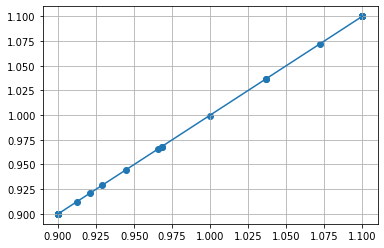

In [471]:
plt.scatter(res_1['data']['x_opt'], res_2['data']['x_opt'])
plt.plot([0.9, 1.1], [0.9, 1.1])
plt.grid()
plt.show()

In [472]:
res_1['data']

,plu_line_idx,P,Q,E,PC,C,plu_idx,x_lower,x_upper,x_init,fixed,x_opt,P_opt,Q_opt
0,0,49.99,1.645534,-0.514843,41.99,44.74,0,0.900000,0.965963,0.932982,0,0.965963,48.288500,1.674624
1,1,54.99,3.032770,-2.288226,52.99,44.18,1,0.900000,1.100000,1.000000,0,0.900000,49.491000,3.812552
2,2,67.99,3.043069,-3.727183,70.99,49.22,2,0.900000,1.100000,1.000000,0,0.900000,61.191000,4.417548
3,3,71.99,4.542928,-2.799188,81.99,58.69,3,0.968072,1.100000,1.034036,0,0.968072,69.691500,4.967637
4,3,71.99,4.542928,-1.541063,81.99,58.69,4,0.968072,1.100000,1.034036,0,0.968072,69.691500,4.772044
5,4,175.99,0.269199,-0.895121,176.99,158.72,5,0.900000,1.100000,1.000000,0,1.100000,193.589000,0.246150
6,5,118.99,1.216094,-0.314968,118.99,74.75,6,0.900000,1.100000,1.000000,0,1.100000,130.889000,1.178388
7,6,124.99,0.534938,-1.011818,130.99,117.75,7,0.900000,1.100000,1.000000,0,1.100000,137.489000,0.483460
8,6,124.99,0.534938,-0.840465,130.99,117.75,8,0.900000,1.100000,1.000000,0,1.100000,137.489000,0.491816
9,7,143.99,1.092008,-1.558281,159.99,100.58,9,0.944451,1.100000,1.022226,0,0.944451,135.991500,1.190745


In [737]:
data_ = generate_data(150, bounds_params, 21, 100)
df = data_['data_nlp']
plu_idx = df.plu_idx
plu_line_idx = df.plu_line_idx
P = df.P
Q = df.Q
E = df.E
C = df.C
M_ = sum((P - C) * Q)

opt_params_ = {
    'alpha': 0.0,
    'con_mrg': M_,
    'con_equal': True,
}


In [738]:
df

,plu_line_idx,P,Q,E,PC,C,plu_idx,x_lower,x_upper,x_init,fixed
0,0,89.99,2.109778,-2.753790,84.99,67.62,0,0.900000,1.086104,0.993052,0
1,1,117.99,1.093764,-0.317092,110.99,80.46,1,0.900000,1.081774,0.990887,0
2,2,50.99,3.359698,-4.191542,52.99,40.24,2,0.900000,1.100000,1.000000,0
3,3,47.99,3.826262,-0.821491,54.99,45.58,3,0.973984,1.100000,1.036992,0
4,3,47.99,3.826262,-0.769721,54.99,45.58,4,0.973984,1.100000,1.036992,0
...,...,...,...,...,...,...,...,...,...,...,...
145,113,81.99,5.736807,-1.281219,70.99,67.39,145,0.900000,0.995713,0.947856,0
146,114,65.99,1.219581,-0.448723,66.99,46.94,146,0.900000,1.100000,1.000000,0
147,114,65.99,1.219581,-0.919968,66.99,46.94,147,0.900000,1.100000,1.000000,0
148,115,119.99,2.544054,-0.879027,129.99,87.04,148,0.920839,1.100000,1.010420,0


In [739]:
%%time
opm = ScipyNlpOptimizationModel(data_, 0.0)
opm.init_variables()
opm.init_objective()
opm.add_con_mrg(M_)
d1 = opm.solve(solver='cobyla')['data']

CPU times: user 5.4 s, sys: 8.85 ms, total: 5.41 s
Wall time: 5.41 s


In [740]:
%%time
d2 = pricing_optimization(data_, PyomoNlpOptimizationModel, opt_params_, 'ipopt')[0]['data']

CPU times: user 33.4 ms, sys: 17.9 ms, total: 51.3 ms
Wall time: 97.3 ms


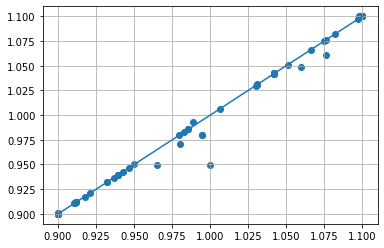

In [741]:
plt.scatter(d1['x_opt'], d2['x_opt'])
plt.plot([0.9, 1.1], [0.9, 1.1])
plt.grid()
plt.show()